(sec:data-visualization)=
# データ可視化と次元圧縮

機械学習において、データを扱う際には、データそのものがどのような性質を持っているかをよ事前に調べておくことが有効である。しかし、多くのデータは多次元のデータであるため、そのままデータがどのような分布になっているかを見ることは難しい。

そこで、データを2次元や3次元といった、人間にとって理解のしやすい次元に落として、データの分布の様子を見ることが必要になる。ここで用いるのが**次元圧縮**である。

次元圧縮には**線形**の次元圧縮と**非線形**の次元圧縮があり、線形の手法は、元のデータに何らかの行列を作用させて、低次元のベクトルを得る。それに対し、非線形の手法は元のデータを入力とする多変数関数を定義することで低次元のベクトルを得る。

次元圧縮を考える際、実際のデータは**高次元空間にランダムに存在している訳ではなく、ある程度の規則に従って散らばっている**ことを意識しておくことが大切である。このようなデータの散らばりは、ある程度、高次元空間上の曲面付近での散らばりと見なせることが多い。この曲面の構造をある種の**多様体**であると見なして、低次元空間への埋め込みを行う方法を、特に**多様体学習**と呼ぶ。

In [1]:
"""
下準備のコード
"""

import random
import warnings

import numpy as np
import seaborn as sns
import matplotlib
from myst_nb import glue

# 乱数の固定
random.seed(31415)
np.random.seed(31415)

# 一部の警告の無視
warnings.simplefilter("ignore", FutureWarning)

# 実験に用いるサンプル数
n_samples = 2000
glue("n_samples", n_samples, display=False)

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

今回は、以下のスイスロールのデータを題材に次元圧縮と可視化の方法について見ていこう。

**スイスロールのデータ**

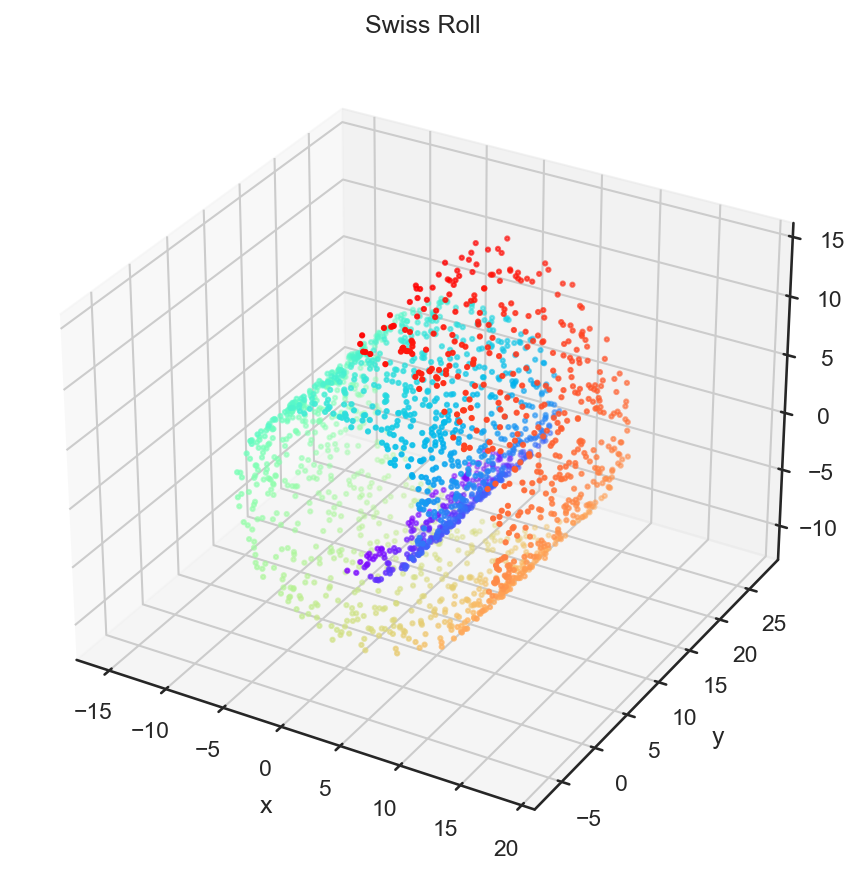

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import cm

# データセットの取り出し
X_sr, y_sr = datasets.make_swiss_roll(n_samples=n_samples, noise=0.1)

# yの値を正規化して、色情報に変換しておく
y_sr = (y_sr - y_sr.min()) / (y_sr.max() - y_sr.min())
c = cm.rainbow(y_sr)

# 三次元プロットの表示
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_sr[:, 0], X_sr[:, 1], X_sr[:, 2], color=c, s=4)
ax.set_title("Swiss Roll")
ax.axis("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

## 線形の次元圧縮

### 主成分分析 (PCA)

**主成分分析** (PCA = Principal Component Analysis)は、データの散らばりが大きい方向に沿うように軸を取って次元圧縮を行う方法である。例えば、2次元空間に射影を行う場合、最も分散が大きな方向と次に分散が大きな方向を計算して、その2つの方向を基底ベクトルとして定義される低次元空間への射影を行う。

このようなデータの散らばりの性質を調べるには、データから定まる分散共分散行列を用いる。分散共分散行列はその固有ベクトルが散らばりの方向を、固有値が散らばりの大きさを表わす。

なお、本資料においては、与えられたデータ$\mathcal{X} = \{ \mathbf{x}_1, \ldots, \mathbf{x}_N \}$が標本ではなく、全てのデータを代表していると考えて、以下のように平均$\boldsymbol\mu$や分散共分散行列$\mathbf{C}$を計算する (情報科学の分野では、厳密性を排除して、このように計算することが多い)。

$$
\begin{aligned}
\boldsymbol{\mu} &= \frac{1}{N} \sum_{i=1}^N \mathbf{x}_i \\
\mathbf{C} &= \frac{1}{N} \sum_{i=1}^N (\bar{\mathbf{x}} - \mathbf{x}_i) (\bar{\mathbf{x}} - \mathbf{x}_i)^\top 
\end{aligned}
$$

NumPyを用いて、平均と分散共分散行列を計算すると、以下のようになる。

In [7]:
# 分散共分散行列の計算
mu_sr = np.mean(X_sr, axis=0, keepdims=True)
C_sr = np.dot((X_sr - mu_sr).T, X_sr - mu_sr) / n_samples

分散共分散行列は実対称行列であるので、固有値と固有ベクトルが必ず実数で求まる(実非対称行列の場合には、固有値や固有ベクトルが複素数になることがある)。固有値を求める場合は`np.linalg.eig`ではなく`np.linalg.eigh` (接尾字の`h`はHermiteの意味)を用いると、より効率が良い。

In [8]:
# 固有値分解
eigval, eigvec = np.linalg.eigh(C_sr)

# 固有値が大きい順にソートして、先頭の2つを取り出す
idx = np.flip(np.argsort(eigval))
eigval = eigval[idx[:2]]
eigvec = eigvec[:, idx[:2]].T

# 固有ベクトルの方向にデータを射影する
z_sr = X_sr @ eigvec.T

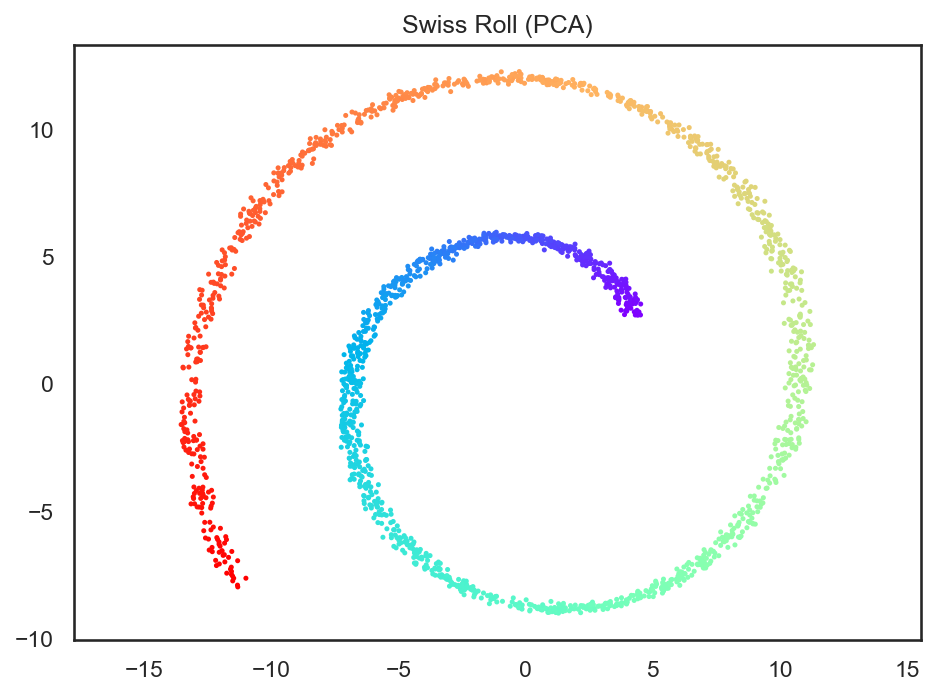

In [9]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Swiss Roll (PCA)")
ax.axis("equal")
plt.tight_layout()
plt.show()

スイスロールのデータを二次元空間にPCAで射影してみると、予想通り、データの散らばりが大きなx軸方向とz軸方向を基底ベクトルとするxz平面上に射影されていることが分かる。

なお、PCAをscikit-learnを用いて実行する場合には、以下のようになる。同様に2次元空間で可視化してみると、先ほどと同じ画像が得られていることが確認できる。

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_sr)
z_sr = pca.transform(X_sr)

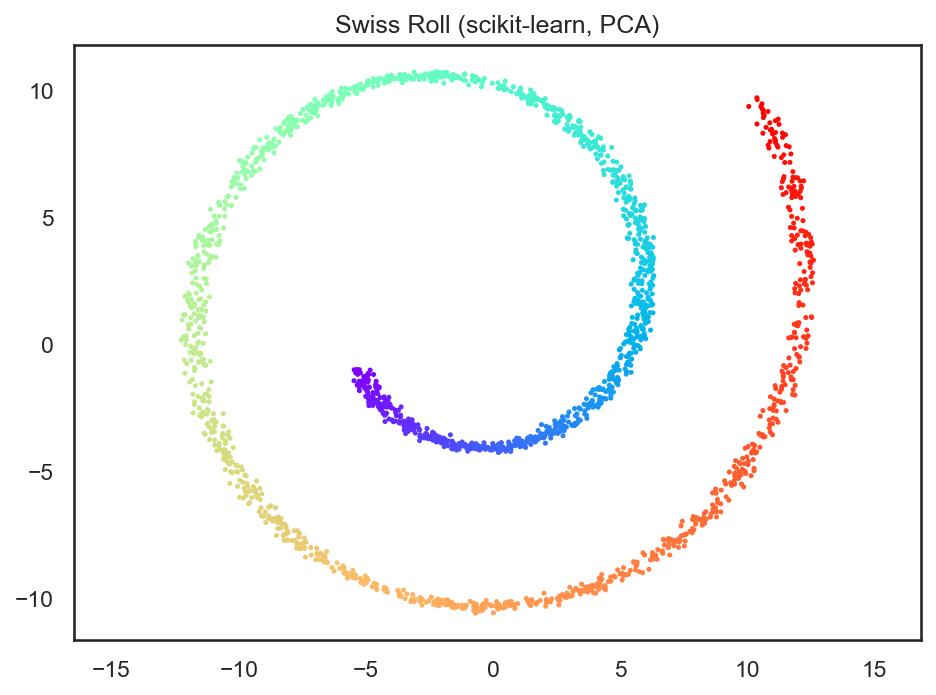

In [14]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Swiss Roll (scikit-learn, PCA)")
ax.axis("equal")
plt.tight_layout()
plt.show()

### 多次元尺度構成法 (MDS)

**多次元尺度構成法**(MDS = Multi-Dimensional Scaling)は距離空間学習法の一種で元の空間における点と点の距離をなるべく保つように低次元空間に点を射影する。今回はデータとデータの間の距離を通常のEuclidノルムで求めて多次元尺度構成法を実行してみる。

多次元尺度構成法では、点と点の間の距離を表わす以下の行列$\mathbf{D} \in \mathbb{R}^{N \times N}$を考える。

$$
D_{ij} = \| \mathbf{x}_i - \mathbf{x}_j \|
$$

低次元空間における$\mathbf{x}_i$のベクトル表現$\mathbf{z}_i$は、この距離をできる限り保つように計算される。すなわち、任意の$\mathbf{z}_i$と$\mathbf{z}_j$の組に対して、

$$
\| \mathbf{z}_i - \mathbf{z}_j \| = D_{ij}
$$ (eq:z-vs-d)

となることが求められる。今、多次元尺度構成法では**距離だけを保てば良い**ので、$\mathbf{x}_1, \ldots, \mathbf{x}_N$の重心が原点となるように平行移動してある、すなわち、

$$
\sum_{i=1}^N \mathbf{x}_i = \mathbf{0}
$$ (eq:center-is-origin)

が成り立つとして、以下の議論を行う。始めに、{eq}`eq:z-vs-d`の両辺を二乗すると、

$$
D_{ij}^2 = \| \mathbf{z}_i \|^2 + \| \mathbf{z}_j \|^2 -2 \mathbf{z}_i^\top \mathbf{z}_j
$$ (eq:D-square)

となる。ここでさらに、

$$
\begin{align}
D_{i*} &= \sum_{j=1}^N D_{ij} \\
D_{*j} &= \sum_{i=1}^N D_{ij} \\
D_{**} &= \sum_{i,j} D_{ij} \\
\end{align}
$$

のように置くと、これらは、{eq}`eq:D-square`ならび{eq}`eq:center-is-origin`から、以下のように計算できる。

$$
\begin{align}
D_{i*} &= N \| \mathbf{z}_i \|^2 + \sum_{j=1} \| \mathbf{z}_j \|^2 \\
D_{*j} &= \sum_{i=1}^N \| \mathbf{z}_i \|^2 + N \| \mathbf{z}_j \|^2 \\
D_{**} &= 2N \sum_{i=1} \| \mathbf{z}_i \|^2
\end{align}
$$

これらの関係式を用いて、$\| \mathbf{z}_i \|^2$, $\| \mathbf{z}_j \|^2$, ならびに$\mathbf{z}_i^\top \mathbf{z}_j$を$D_{i*}$, $D_{*j}$, ならびに$D_{**}$を用いて書き直す。結果だけを示すと以下のようになる。

$$
\begin{align}
\| \mathbf{z}_i \|^2 &= \frac{1}{N} D_{*j}^2 - \frac{1}{2N^2} D_{**} \\
\| \mathbf{z}_j \|^2 &= \frac{1}{N} D_{i*}^2 - \frac{1}{2N^2} D_{**} \\
\mathbf{z}_i^\top \mathbf{z}_j &= \frac{1}{2} \left( \frac{1}{N} D_{i*}^2 + \frac{1}{N} D_{*j}^2 - \frac{1}{N^2} D_{**}^2 - D_{ij}^2 \right)
\end{align}
$$

最後の式を用いると、$\mathbf{Z} = [ \mathbf{z}_1 \cdots \mathbf{z}_N ] \in \mathbb{R}^{M \times N}$に対して、

$$
\mathbf{Z}^\top \mathbf{Z} = -\frac{1}{2} \mathbf{H} \mathbf{D}^2 \mathbf{H}
$$ (eq:mds)


という式が成り立つ。なお、ここでは、$\mathbf{D}^2$は$\mathbf{D}$の各要素を二乗したものであるとし、$\mathbf{H}$は以下のように定義される。

$$
\mathbf{H} = \mathbf{I} - \frac{1}{N} \mathbf{1} \mathbf{1}^\top
$$

ただし、$\mathbf{I}$は単位行列、$\mathbf{1}\mathbf{1}^\top$は全ての要素が1の$N\times N$要素を持つ行列であるとする。

今、{eq}`eq:mds`の右辺を$\mathbf{K}$と置くこととすると、$\mathbf{K}$は半正定値行列であり、$\mathbf{Z}$の解として、以下が得られる。

$$
\mathbf{Z} = [ \sqrt{\lambda_1} \mathbf{u}_1 \cdots \sqrt{\lambda_M} \mathbf{u}_M ]^\top
$$

ただし、$\{ \lambda_i \in \mathbb{R} : i = 1, \ldots, N \}$は、$\mathbf{K}$の固有値を絶対値が大きい順に並べたものであり、$\{ \mathbf{u}_i \in \mathbb{R}^{N} : i = 1, \ldots, N \}$は、それに対応する固有ベクトルである。

---

では、以上の議論を元にスイスロールのデータに対して多次元尺度構成法を適用してみる。なお、今回は、固有値分解を行う対象の行列が巨大であるため、SciPyの`eigh`関数を用いて、絶対値が大きい順に先頭から2個だけ固有値と固有ベクトルを求める。

In [15]:
import scipy as sp

# 距離行列の計算
n = len(X_sr)
D_sr = np.sqrt(np.sum((X_sr[:, None] - X_sr[None, :]) ** 2.0, axis=2))

# MDS
H = np.eye(n) - np.ones((n, n)) / n
K_sr = -0.5 * (H @ (D_sr**2.0) @ H)

eigval, eigvec = sp.linalg.eigh(K_sr, subset_by_index=(n - 2, n - 1))

eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)
z_sr = eigvec * np.sqrt(np.maximum(0.0, eigval[None, :]))

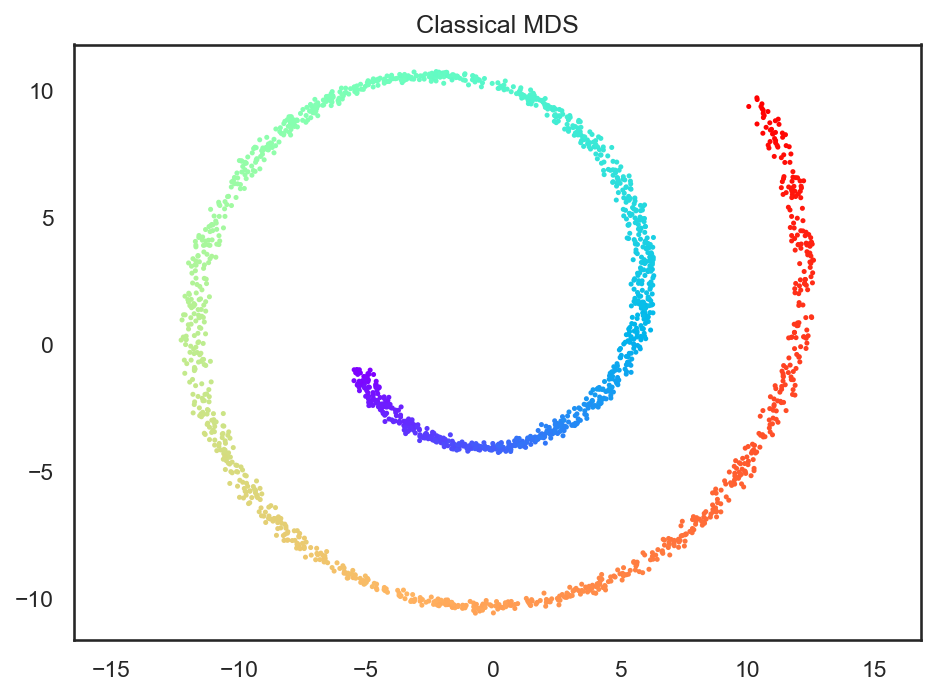

In [16]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Classical MDS")
ax.axis("equal")
plt.tight_layout()
plt.show()

この多次元尺度構成法の結果は、定義式から分かるとおり、元のベクトルを線形に射影した物であり、元々のスイスロールのデータをとある方向 (元の空間での距離が最大限保たれる方向)から見たものと等価である。従って、主成分分析と比べて、ややスイスロールの帯の部分に拡がりのあるデータとなっているものの、全体の見た目としてはそれほど変わりがないことが分かる。

一方で、MDSにはデータの間の距離を調整するSMACOF(Scaling by MAjorizing a COmplicated Function)というテクニック{cite}`leeuw1977application`が知られている。SMACOFは、$\mathbf{Z}$をランダムに初期化した状態からスタートし、$\mathbf{Z}$から求まる距離行列$\mathbf{D}'$が目的の距離行列$\mathbf{D}$に近づくように、Guttman変換と呼ばれる変換を用いて$\mathbf{Z}$を更新していく。これにより、元の多次元尺度構成法とは異なった非線形変換による低次元空間表現を得ることができ、低次元空間でのデータ$\{ \mathbf{z}_1, \ldots, \mathbf{z}_N\}$の配置が、より元の空間での距離を反映した物にすることができる。

SMACOFでは**ストレス** $S$と**比率行列** $R$を、現在の$\mathbf{Z}$から求まる距離行列$\mathbf{D}'$を用いて以下のように定義する。

$$
\begin{align}
S &= \frac{1}{2} \| \mathbf{D}' - \mathbf{D} \|_F \\
\mathbf{R} &= (D_{ij} / (D'_{ij} + \varepsilon))_{ij}
\end{align}
$$

と定義する。なお、ここで$\varepsilon$はゼロ除算を防ぐための微小な実数、$( m(i, j) )_{ij}$は$i$行$j$列の要素が$m(i, j)$であるような行列を表すとする。ここで$\mathbf{R}$からGuttman変換 $\mathbf{B} \in \mathbb{R}^{N \times N}$を次のように定義する。

$$
\mathbf{B} = \frac{1}{N} \left( \text{diag}_i \left( \sum_{k=1}^N R_{ik} \right) - \mathbf{R} \right)
$$

ただし、$\text{diag}_i ( m(i) )$は$m(i)$を$i$番目の対角要素とするような対角行列であるとする。この$\mathbf{B}$を用いて、次のように$\mathbf{Z}$を更新する。

$$
\mathbf{Z}_{\rm new} = \mathbf{B} \mathbf{Z}
$$

この式は、ストレス$S$を最急降下法により最小化する場合の更新ルールに対応しており、この変換を繰り返すことで、ストレス、即ち低次元空間表現から求まる距離行列と、目的の距離行列の相対フロベニウスノルムを最小化することができる。

---

上記のSMACOFの数式をコードに落とすと以下のようになる。

In [17]:
from tqdm.notebook import tqdm

# SMACOFのパラメータ
eps = 1.0e-6
max_iter = 100
k = 2

# Zおよびストレスの初期化
rng = np.random.RandomState(0)
z_sr = rng.uniform(size=(n, k))
old_stress = 1.0e20

# SMACOF iterations
for _ in tqdm(range(max_iter)):
    # Zから距離行列を計算
    D_sr_prime = np.sqrt(np.sum((z_sr[:, None] - z_sr[None, :]) ** 2, axis=2))

    # Guttman transformによるZの更新
    ratio = D_sr / (D_sr_prime + 1.0e-5)
    B = (np.diag(ratio.sum(axis=1)) - ratio) / n
    z_sr = np.dot(B, z_sr)

    # ストレスの計算
    stress = ((D_sr_prime.ravel() - D_sr.ravel()) ** 2).sum() / 2
    rel_stress = stress / np.sqrt((z_sr**2).sum(axis=1)).sum()

    # ストレスの変化が一定以下になったら処理を終了
    if np.abs(old_stress - rel_stress) < eps:
        break

    old_stress = rel_stress

  0%|          | 0/100 [00:00<?, ?it/s]

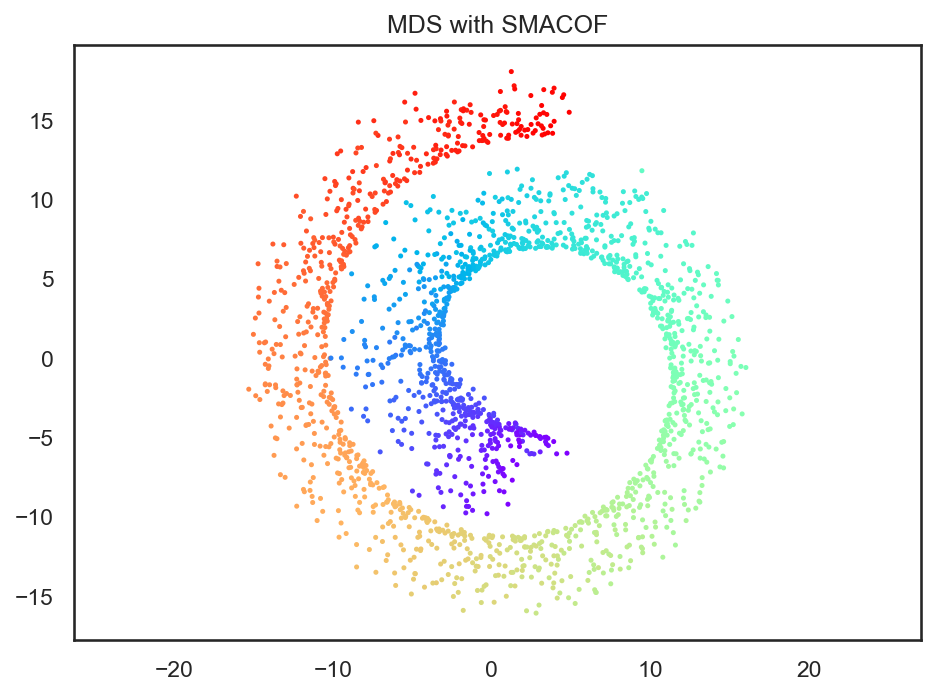

In [18]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("MDS with SMACOF")
ax.axis("equal")
plt.tight_layout()
plt.show()

すると、先ほどのSMACOFを用いない多次元尺度構成法と比べて、よりスイスロールの帯が広がったような結果となっていることが確認でき、SMACOFにより、観測空間におけるデータ間の距離がより保存される形で次元圧縮できていることが分かる。

このSMACOFを用いた実装はscikit-learnでのデフォルト実装となっており、上記と同様の結果は、scikit-learnにより以下のコードで得ることができる。

In [19]:
from sklearn.manifold import MDS

# 距離行列が求まっている場合には「dissimilarity="precomputed"」を指定する
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    n_init=1,
    max_iter=100,
    random_state=np.random.RandomState(0),
    normalized_stress=False,
)
z_sr = mds.fit_transform(D_sr)

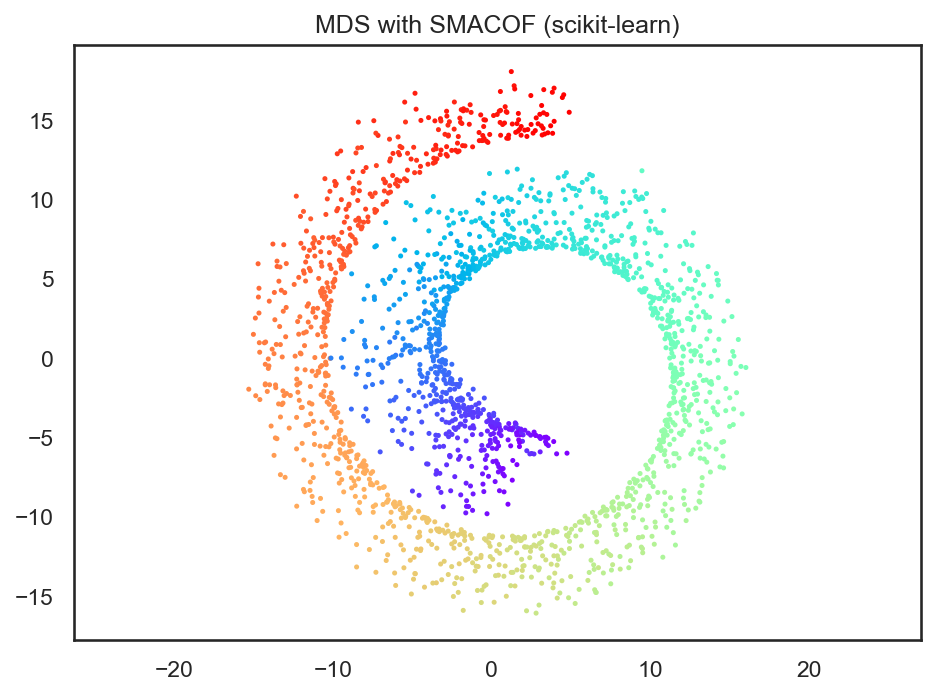

In [20]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("MDS with SMACOF (scikit-learn)")
ax.axis("equal")
plt.tight_layout()
plt.show()

## 非線形の次元圧縮

### ISOMAP

**ISOMAP**は多次元尺度構成法の拡張の一種で、**データ間の距離の計算にk-nearest neighbor graph (kNNグラフ)上で計算された測地距離**を用いる。なお、kNNグラフとは、各点とその近傍を結んで作られるグラフ構造を指す。このようなグラフを作成するために、以下のコードでは [KD木](https://en.wikipedia.org/wiki/K-d_tree)を用いた最近某探索を用いる。

In [21]:
from sklearn.neighbors import NearestNeighbors

# 各データ点に対する最近傍点の探索
n_neighbors = 20
kd_tree = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="kd_tree")
kd_tree.fit(X_sr)
distances, indices = kd_tree.kneighbors(X_sr)

# 自分自身までの距離を除去
distances = distances[:, 1:]
indices = indices[:, 1:]

ここで`distances`と`indices`は`[1000, 5]`の大きさのデータになっていて、各頂点に対する近傍点までの距離と、近傍点のインデックスが入っている。なお、探索元のデータ群と探索先のデータ群を同じにすると、`distances[:, 0]`が自分自身の点までの距離で0となってしまうため、kNNグラフを作る際には、このようなデータを除去しておく。

次にグラフ計算のためのライブラリである`networkx`を用いて、グラフ上での点と点の距離を計算する。まずはグラフの作成。`networkx`でグラフを作成するためには`(i, j, {"weight": 1.0})`のような辺の端点を表わす点のインデックス`i`, `j`と、辺に対する重みの除法を表わす`{"weight": 1.0}`を辺の数分だけ配列に格納し、その配列を用いて `from_edgelist` からグラフを作成する。

In [22]:
# kNNグラフの作成
import networkx as nx

# 辺のデータの収集
edges = []
for i in range(n):
    for j in range(n_neighbors):
        edges.append((i, indices[i, j], {"weight": distances[i, j]}))
        edges.append((indices[i, j], i, {"weight": distances[i, j]}))

# グラフの作成
G = nx.from_edgelist(edges)

グラフが作成できたら、[Warshall-Floyd法](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm)によって、全点対間の距離を計算する。なお、Warshall-Floyd法はグラフの頂点数 $N$に対して $O(N^3)$のアルゴリズムなので、計算量に注意すること。

In [23]:
# Warshall-Floyd法による全点対間距離の計算
# 注意: networkxのグラフのノードはインデックス順になっていないので、第2引数にノード順を指定する
D_sr = nx.floyd_warshall_numpy(G, nodelist=np.arange(n))

ここまででkNNグラフ上での頂点間距離が求まったので、この距離行列を用いて多次元尺度構成法と同様の計算を行う。

In [24]:
n = len(X_sr)
H = np.eye(n) - np.ones((n, n)) / n
K = -0.5 * (H @ (D_sr**2) @ H)

eigval, eigvec = sp.linalg.eigh(K, subset_by_index=(n - 2, n - 1))
eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)

z_sr = eigvec * np.sqrt(eigval[None, :])

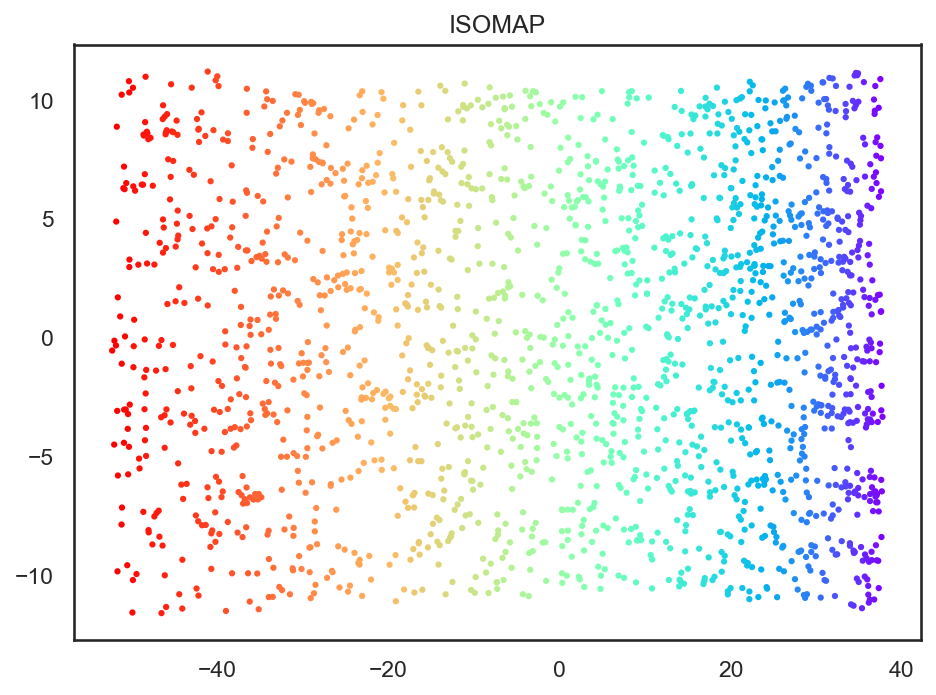

In [25]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=4)
ax.set_title("ISOMAP")
plt.tight_layout()
plt.show()

ここまでと同様の結果は、scikit-learnの`Isomap`でも得ることができる。`Isomap`はパラメータにkNNグラフを作成するためのアルゴリズム`neighbors_algorith`と、グラフ上の距離を計算するためのアルゴリズム`path_method`を取る。今回は、上記のコードに合わせて`"kd_tree"`と`"FW"` (Floyd-Warshallの頭文字)を指定してある。

In [26]:
from sklearn.manifold import Isomap

isomap = Isomap(
    n_components=2,
    n_neighbors=20,
    neighbors_algorithm="kd_tree",
    path_method="FW",
)
z_sr = isomap.fit_transform(X_sr)

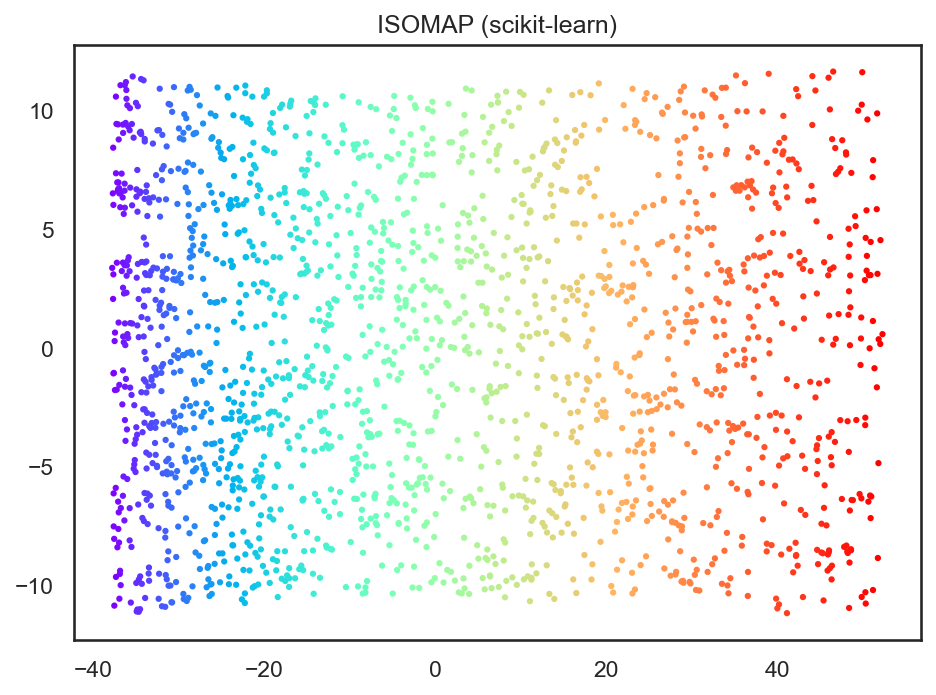

In [27]:
# データの可視化
fig, ax = plt.subplots()
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=4)
ax.set_title("ISOMAP (scikit-learn)")
plt.tight_layout()
plt.show()

### 局所線形埋め込み法 (LLE)

**局所線形埋め込み法** (LLE = Locally Linear Embedding) {cite}`roweis2000nonlinear`は、その名前が示す通り、高次元空間上の点である$\mathbf{x}_i$とその近傍において、線形性を保存するように低次元空間での表現を得る次元圧縮法である。

今、$\mathbf{x}_i \in \mathbb{R}^D$の近傍点として、$\mathbf{x}_{i_1}, \ldots, \mathbf{x}_{i_K}$が与えられたとしよう。ここでいう線形性とは、$\mathbf{x}_i$が近傍点の凸結合として、以下のように表せることを意味する。

$$
\mathbf{x}_i = \sum_{k=1}^K w_{ik} \mathbf{x}_{i_k}, \quad \forall i, \forall k, ~~ w_{ik} \geq 0, ~~ \sum_{k=1}^K w_{ik} = 1
$$

この式に対して$\mathbf{d}_{i_k} = \mathbf{x}_{i_k} - \mathbf{x}_i$とおいて、$\mathbf{D}_i = [ \mathbf{d}_{i_1} \cdots \mathbf{d}_{i_K} ] \in \mathbb{R}^{K \times D}$, $\mathbf{w}_i = (w_{i1} \cdots w_{iK})^\top \in \mathbb{R}^K$と置くことで、以下のように書き直せる。

$$
\mathbf{D}_i^\top \mathbf{w}_i = \mathbf{0}
$$

これを用いると、解くべき最適化問題は次のようになることが分かる。

$$
\begin{align}
& \underset{\mathbf{w}_i}{\text{minimize:}} \quad \frac{1}{2} \| \mathbf{D}_i^\top \mathbf{w}_i \|^2 \\
&\begin{aligned}
    \text{subject to:} \quad & \mathbf{1}^\top \mathbf{w}_i = 1 & \\
    & w_{ik} \geq 0 & (i = 1, \ldots, K)
\end{aligned}
\end{align}
$$ (eq:lle-weight-derivation)

この最適化問題は不等式制約を含むため、目的関数が二次、制約条件が一次であるものの、単純な線形問題には帰着されない。具体的にはKarush-Kuhn-Tucker条件 (KKT条件)を満たすように、以下のラグランジアンに関する制約付き最適化問題を解く必要がある。

$$
\mathcal{L}(\mathbf{w}_i, \beta, \boldsymbol\mu) = \frac{1}{2} \| \mathbf{D}_i^\top \mathbf{w}_i \|^2 - \lambda (\mathbf{1}^\top \mathbf{w}_i - 1) - \sum_{k=1}^K \mu_k w_{ik}
$$

このラグランジアンを用いると、{eq}`eq:lle-weight-derivation`のKKT条件は以下のように書ける。

$$
\begin{align}
\nabla \mathcal{L} = \mathbf{0}, & &\\
w_{ik} \geq 0, & & k = 1, \ldots, K \\
\mu_k w_{ik} = 0, & & k = 1, \ldots, K \\
\mu_k \geq 0, & & k = 1, \ldots, K
\end{align}
$$

すると、ラグランジアンの勾配が$\mathbf{0}$になるという条件から、

$$
\mathbf{D}_i \mathbf{D}_i^\top \mathbf{w}_i = \lambda \mathbf{1} + \boldsymbol\mu
$$

となることが分かる。この時、行列 $\mathbf{D}_i \mathbf{D}_i^\top$が半正定値行列であることを考慮すると、両辺に左側から$\mathbf{w}_i^\top$を書けることにより、以下の不等式が得られる。

$$
\lambda \mathbf{1}^\top \mathbf{w}_i + \boldsymbol\mu^\top \mathbf{w}_i = \mathbf{w}_i (\mathbf{D}_i \mathbf{D}_i^\top) \mathbf{w}_i \geq 0
$$

KKT条件より任意の$k$について$\mu_k w_{ik} = 0$であるので、結局、以下のように書ける。

$$
\frac{1}{2} \| \mathbf{D}_i^\top \mathbf{w}_i \|^2 = \frac{1}{2} \mathbf{w}_i (\mathbf{D}_i \mathbf{D}_i^\top) \mathbf{w}_i \geq \frac{1}{2} \lambda \mathbf{1}^\top \mathbf{w}_i
$$

以上より、{eq}`eq:lle-weight-derivation`を満たすように$\frac{1}{2} \| \mathbf{D}_i^\top \mathbf{z}_i \|^2$を最小化するとき、その最小値は$\frac{1}{2} \lambda \mathbf{1}^\top \mathbf{w}_i$になることが分かる。

よって、その時の$\mathbf{w}_i$を求めるためには、等式を満たす場合に関して、両辺を$\mathbf{w}_i$で微分することにより得られる以下の線形方程式を解けば良い。

$$
\mathbf{D}_i \mathbf{D}_i^\top \mathbf{w}_i = \frac{1}{2} \lambda \mathbf{1}
$$

ここで、$\lambda$が未知であったことを考慮し、以下のように問題を書き換える。

$$
\mathbf{D}_i \mathbf{D}_i^\top \mathbf{w}'_i = \mathbf{1}
$$

ただし、$\mathbf{w}'_i = \frac{2}{\lambda} \mathbf{w}_i$とする。今、この線形方程式を解いて$\mathbf{w}'_i$が求まれば、$w_{ik}$の和が1であったことから、

$$
\mathbf{w}_i = \frac{{w}'_i}{\sum w'_{ik}}
$$

と書ける。これで、とある頂点$\mathbf{x}_i$について、その近傍から$\mathbf{x}_i$を凸結合により表現するための重み$w_{ik}$を求めることができた。

---

局所線形埋め込みにおいては$\mathbf{x}_i$に対応する低次元空間表現$\mathbf{z}_i \in \mathbb{R}^d ~ (d \leq D)$が同じ局所線形性を有することを仮定する。即ち、

$$
\mathbf{z}_i = \sum_{k=1}^K w_{ik} \mathbf{z}_{i_k}, \quad \forall i, \forall k, ~~ w_{ik} \geq 0, ~~ \sum_{k=1}^K w_{ik} = 1
$$

が成立すると仮定する。これを全てのデータ点に対して考慮すれば、解くべき問題は以下の二乗誤差の最小化に帰着される。

$$
\sum_{i=1}^N \left\| \mathbf{z}_i - \sum_{k=1} w_{ik} \mathbf{z}_{i_k} \right\|^2 = \mathbf{z}^\top (\mathbf{I} - \mathbf{W})^\top (\mathbf{I} - \mathbf{W}) \mathbf{z}
$$ (eq:lle-quadratic-form)

ただし、行列$\mathbf{W}$は、その$i$行において$i_1, \ldots, i_K$列の成分だけが非零の値を持つような疎行列、$\mathbf{Z} = [ \mathbf{z}_i \cdots \mathbf{z}_N ]^\top \in \mathbb{R}^{N\times d}$である。

{eq}`(eq:lle-quadratic-form) は、行列 $\mathbf{M} = (\mathbf{I} - \mathbf{W})^\top (\mathbf{I} - \mathbf{W})$の二次形式なので、これを最小化するためには、$\mathbf{z}$を$\mathbf{M}$の固有値の絶対値が小さい順に、固有ベクトルを並べて、

$$
\mathbf{z} = [\mathbf{u}_2 \cdots \mathbf{u}_{d+1}]
$$

とすれば良いことが分かる。ただし、$\mathbf{M}$は半正定値行列で、絶対値最小の固有値$\lambda_1 = 0$であるため、これに対応する固有ベクトル$\mathbf{u}_1$を除いて、先頭から$d$個を並べている。

以上の計算により、局所線形埋め込み法による低次元空間表現が得られた。

---

以上を踏まえて、局所線形埋め込み法のコードを書いてみよう。

In [28]:
# 各データ点に対する最近傍点の探索
n = len(X_sr)
n_neighbors = 20
kd_tree = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="kd_tree")
kd_tree.fit(X_sr)
distances, indices = kd_tree.kneighbors(X_sr)

# 自分自身までの距離を除去
distances = distances[:, 1:]
indices = indices[:, 1:]

In [29]:
# 各データ点における重心結合の係数を計算
rows = []
cols = []
ws = []
for i in range(n):
    X_knn = X_sr[indices[i]]
    X_knn = X_knn - X_sr[i]

    # 線形問題の計算
    AA = X_knn @ X_knn.T
    eps = 1.0e-3
    tr = np.trace(AA)
    if tr > 0.0:
        eps *= tr

    AA += np.identity(AA.shape[0]) * eps
    bb = np.ones((n_neighbors))
    w_i = np.linalg.solve(AA, bb)

    # w_iを要素の合計が1になるように正規化
    w_i = w_i / np.sum(w_i)

    rows.extend([i] * n_neighbors)
    cols.extend(indices[i])
    ws.extend(w_i.tolist())

In [30]:
import scipy.sparse

W = sp.sparse.csr_matrix((ws, (rows, cols)), shape=(n, n))
I = sp.sparse.dia_matrix((np.ones(n), 0), shape=(n, n))
M = (I - W).T @ (I - W)

In [31]:
eigval, eigvec = sp.sparse.linalg.eigsh(M, k=3, which="LM", sigma=0.0)
idx = np.argsort(np.abs(eigval))
eigvec = eigvec[:, idx[1:]]
z_sr = eigvec

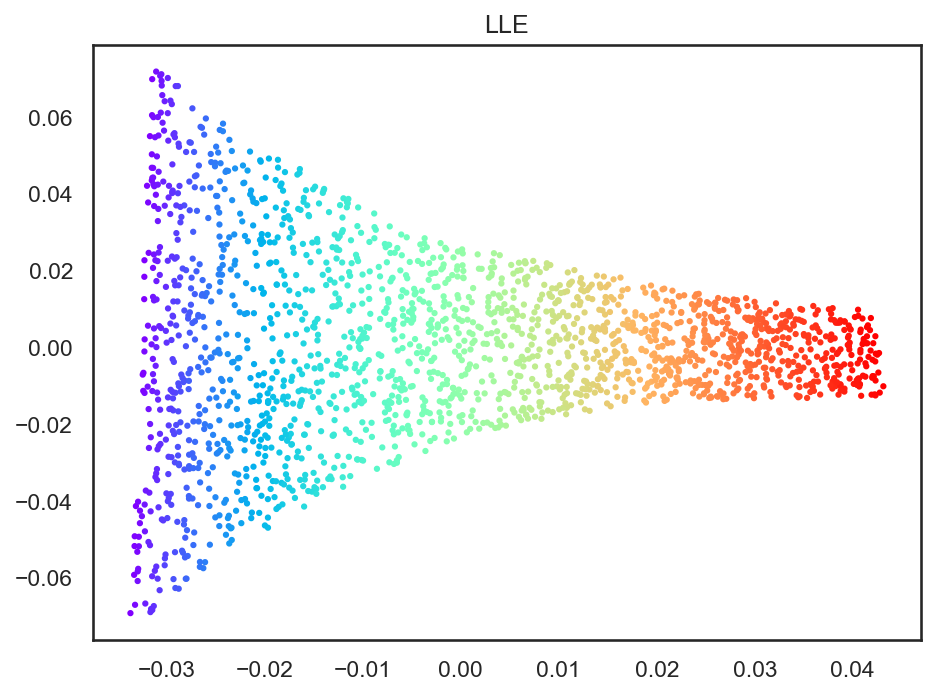

In [32]:
# データの可視化
fig, ax = plt.subplots()
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=4)
ax.set_title("LLE")
plt.tight_layout()
plt.show()

以上のように、局所線形埋め込みを用いることで、スイスロールの巻き込み形状を、ISOMAP同様、シート状に伸ばすことができた。

上記と同様の結果はscikit-learnを用いて、以下のコードで得ることができる。

In [33]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20, method="standard")
z_sr = lle.fit_transform(X_sr)

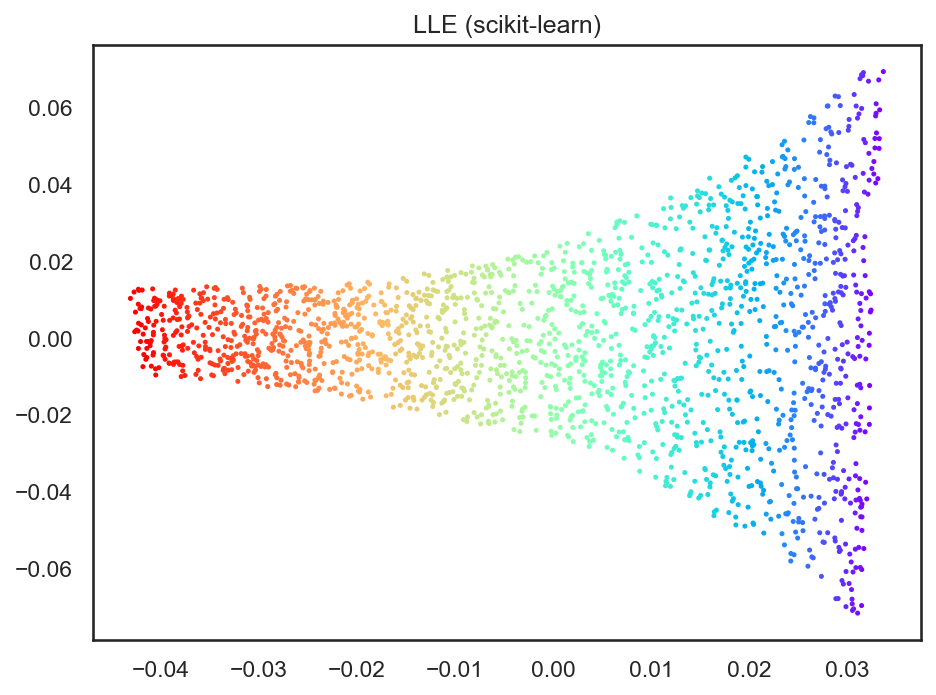

In [34]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("LLE (scikit-learn)")
plt.tight_layout()
plt.show()

局所線形埋め込み法には、その発展形として、改良局所線形埋め込み法 (Modified LLE) {cite}`zhang2006mlle` やHessian Eigenmap {cite}`donoho2003hessian` などがある。興味のある読者は是非、原論文を当たってみてほしい。

### カーネル主成分分析

**カーネル主成分分析**は[サポートベクトルマシン](ssec:support-vector-machine)の項で紹介したカーネル法を用いた主成分分析の拡張である。カーネル法では、与えられたデータ$\mathbf{x}_i$をとある線形汎関数$\phi \in \mathcal{H}$を用いて、$\phi(\mathbf{x}_i)$のように変換する。カーネル主成分分析はこの$\phi(\mathbf{x}_i)$に対して主成分分析を行う手法である。

今、仮に$\phi(\mathbf{x}_i)$の平均が原点にあると仮定すると、その分散共分散行列$C: \mathcal{H} \mapsto \mathcal{H}$は次のように書ける (今、$\phi$が線形汎関数であるので、分散共分散行列がヒルベルト空間$\mathcal{H}$上の線形演算子になっていることに注意)。

$$
C(u, v) = \frac{1}{N} \sum_{i=1}^N \phi(\mathbf{x}_i)(u) \phi(\mathbf{x}_i)(v)
$$ (eq:kpca-covariance)

しかし、一般に関数$\phi$は未知であり、$\phi(\mathbf{x}_i)$がどのような形になるかを知ることはできない。そこで、$C$を陽に求める代わりに、カーネル法を用いて、主成分分析の結果だけを求めることを試みる。

まずは、主成分分析の見方について再考する。主成分分析は、分散共分散行列の固有ベクトルを求めて、その方向を基底とする部分空間にデータを射影するのであった。

この時、固有ベクトルの方向はデータ分散が大きくなる方向であったことを思いだしてほしい。従って、とあるベクトルの集合$\mathbf{x}_1, \ldots, \mathbf{x}_N$について、第一主方向を求める問題は、**とある単位ベクトル$\mathbf{w}, \| \mathbf{w} \| = 1$について、$\mathbf{w}^\top \mathbf{x}_i$の分散を最大化する問題**に他ならない。

今、$\mathbf{x}_i$のサンプル平均を$\boldsymbol\mu$とすると、$\mathbf{w}$に沿った分散$V$は以下のように書ける。

$$
\begin{align}
V
&= \frac{1}{N} \sum_{i=1}^N (\mathbf{w}^\top (\mathbf{x}_i - \boldsymbol\mu))^2 \\
&= \mathbf{w}^\top \left( \frac{1}{N} \sum_{i=1}^N (\mathbf{x}_i - \boldsymbol\mu) (\mathbf{x}_i - \boldsymbol\mu)^\top \right) \mathbf{w}
\end{align}
$$

最後の式の**大括弧の中身は分散共分散行列に他ならない**。主成分方向が分散共分散行列の固有ベクトルによって与えられるのは、この式を最大化しているためである。

---

次に、これを$\phi(\mathbf{x}_i), i = 1, \ldots, N$を考え、その平均を関数$\mu \in \mathcal{H}$で表わす。とある線形汎関数$\psi \in \mathcal{H}$の方向に沿った分散$V$は

$$
V = \frac{1}{N} \sum_{i=1}^N \langle \psi, \phi(\mathbf{x}_i) - \mu \rangle^2, \quad \mu = \frac{1}{N} \sum_{i=1}^N \phi(\mathbf{x}_i)
$$ (eq:kpca-variance)

のように書ける。ただし $\| \psi \|^2 = \langle \psi, \psi \rangle = 1$である。この分散の値を考える場合、$\psi$と内積を取る相手は$\phi(\mathbf{x}_i) - \mu$に限定されているため、

$$
\psi = \sum_{j=1}^N \alpha_j (\phi(\mathbf{x}_j) - \mu)
$$ (eq:kpca-psi)

のように表わしても、内積の値は変化せず、故に分散の値も変化しない (三次元空間において、内積を取る相手のベクトルがとある平面内にしか存在しない場合を考えるとイメージがつきやすい)。

{eq}`eq:kpca-psi`を{eq}`eq:kpca-variance`に代入し、更に$k(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i, \mathbf{x}_j)$の性質を用いると、分散$V$は次のように書き直せる。

$$
\begin{equation}
V = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^N \alpha_j \langle \phi(\mathbf{x}_i) - \mu, \phi(\mathbf{x}_j) - \mu \rangle^2
\end{equation}
$$ (eq:kpca-quadratic)

このとき、

$$
\begin{align}
\langle \phi(\mathbf{x}_i) - \mu, \phi(\mathbf{x}_j) - \mu \rangle
&= k(\mathbf{x}_i, \mathbf{x}_j) + \frac{1}{N} \sum_{i=1}^N k(\mathbf{x}_i, \mathbf{x}_j) + \frac{1}{N} \sum_{j=1}^N k(\mathbf{x}_i, \mathbf{x}_j) + \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1}^N k(\mathbf{x}_i, \mathbf{x}_j)
\end{align}
$$

となる。カーネル行列$\mathbf{K}$を$K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$となるように定め、さらに、

$$
\mathbf{H} = \mathbf{I} - \frac{1}{N} \mathbf{1} \mathbf{1}^\top
$$

とおくと、{eq}`eq:kpca-quadratic`は以下のように書き直せる。

$$
V = \boldsymbol\alpha^\top (\mathbf{H} \mathbf{K} \mathbf{H})^2 \boldsymbol\alpha
$$

ただし、$\boldsymbol\alpha = (\alpha_1, \ldots, \alpha_N)^\top$である。以上より、分散を最大化させるような$\psi$を与える係数$\boldsymbol\alpha$は$\mathbf{H}\mathbf{K}\mathbf{H}$に対して、固有値の絶対値が大きい順に固有ベクトルをいくつか取ることで、カーネル主成分分析における主成分方向を得ることができる。

この時、$\boldsymbol\alpha$は固有ベクトルから求まるが、実際には、固有ベクトルに定数倍の曖昧さが存在するため、固有ベクトル$\mathbf{u}$をそのまま$\boldsymbol\alpha$として用いても $\| \psi \| = 1$とはならない。

そこで、$\boldsymbol\alpha = t \mathbf{u}, \| \mathbf{u} \| = 1$であるとして、$\| \psi \|^2 = \langle \psi, \psi \rangle$を求めて、その大きさで正規化する。

$$
\begin{align}
\langle \psi, \psi \rangle &= \sum_{i=1}^N \sum_{j=1}^N t u_i t u_j \langle \phi(\mathbf{x}_i) - \mu, \phi(\mathbf{x}_j) - \mu \rangle \\
&= t^2 \mathbf{u}^\top \left( \mathbf{H K H} \right) \mathbf{u}　\\
&= t^2 \lambda = 1
\end{align}
$$

従って、$\psi$を与える係数$\boldsymbol\alpha$は$\mathbf{H K H}$の固有値$\lambda$と固有ベクトル$\mathbf{u}$を用いて、

$$
\boldsymbol\alpha = \frac{\mathbf{u}}{\sqrt{\lambda}}
$$

となる。

ここで、とある$\phi(\mathbf{x}_i)$の主成分分析による低次元表現$\mathbf{z}_i$を計算すると、その第$j$成分は固有関数$\psi_j$を用いて、

$$
\begin{align}
z_{ij} &= \langle \psi_j, \phi(\mathbf{x}_i) - \mu \rangle \\
&= \sum_{k=1}^N \alpha_{jk} \left\langle \phi(\mathbf{x}_k) - \frac{1}{N} \sum_{l=1}^N \phi(\mathbf{x}_l), \phi(\mathbf{x}_i) - \frac{1}{N} \sum_{m=1}^N \phi(\mathbf{x}_m) \right\rangle \\
&= \sum_{k=1}^N \alpha_{jk} \left( k(\mathbf{x}_k, \mathbf{x}_i) - \frac{1}{N} \sum_{l=1}^N k(\mathbf{x}_l, \mathbf{x}_i) - \frac{1}{N} \sum_{m=1}^N k(\mathbf{x}_i, \mathbf{x}_m) + \frac{1}{N^2} \sum_{l=1}^N \sum_{m=1} k(\mathbf{x}_l, \mathbf{x}_m) \right)
\end{align}
$$

とかける。従って、$\mathbf{Z} = [\mathbf{z}_1, \ldots, \mathbf{z}_N]^\top \in \mathbb{R}^{N \times d}$とすると、$\mathbf{Z}$は行列$\mathbf{HKH}$を用いて、

$$
\mathbf{Z} = \mathbf{HKH} \begin{bmatrix} \boldsymbol\alpha_1 & \ldots & \boldsymbol\alpha_d \end{bmatrix} = \mathbf{HKH} \begin{bmatrix} \frac{\mathbf{u}_1}{\sqrt{\lambda_1}} & \ldots & \frac{\mathbf{u}_d}{\sqrt{\lambda_d}} \end{bmatrix}
$$

となることが分かる。

---

では、ここまでの議論を元にカーネル主成分分析を実装してみよう。

In [35]:
# カーネル行列の計算
n = len(X_sr)
gamma = 0.01
H = np.eye(n) - np.ones((n, n)) / n
D_sr = np.sqrt(np.sum((X_sr[:, None] - X_sr[None, :]) ** 2.0, axis=2))
K_sr = np.exp(-gamma * D_sr**2.0)
K_sr = H @ K_sr @ H

# カーネル行列の最大固有値を求める
eigval, eigvec = sp.linalg.eigh(K_sr, subset_by_index=(n - 2, n - 1))
eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)

# 低次元空間表現を得る
z_sr = K_sr @ eigvec / np.sqrt(eigval[None, :])

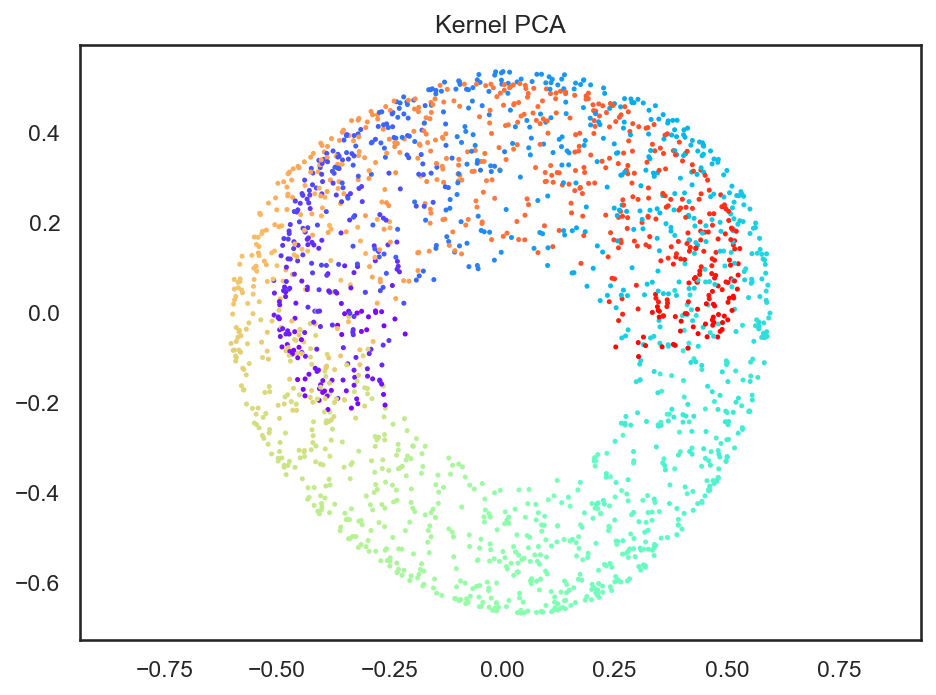

In [36]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Kernel PCA")
ax.axis("equal")
plt.tight_layout()
plt.show()

このようにカーネル法を用いたことで、単なる主成分分析とは異なり、非線形の射影によって、データ全体がより一様に近い形で低次元空間に射影されていることが分かる。

上記と等価のコードをscikit-learnによって実現すると以下のようになる。

In [37]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel="rbf", gamma=0.01)
z_sr = kpca.fit_transform(X_sr)

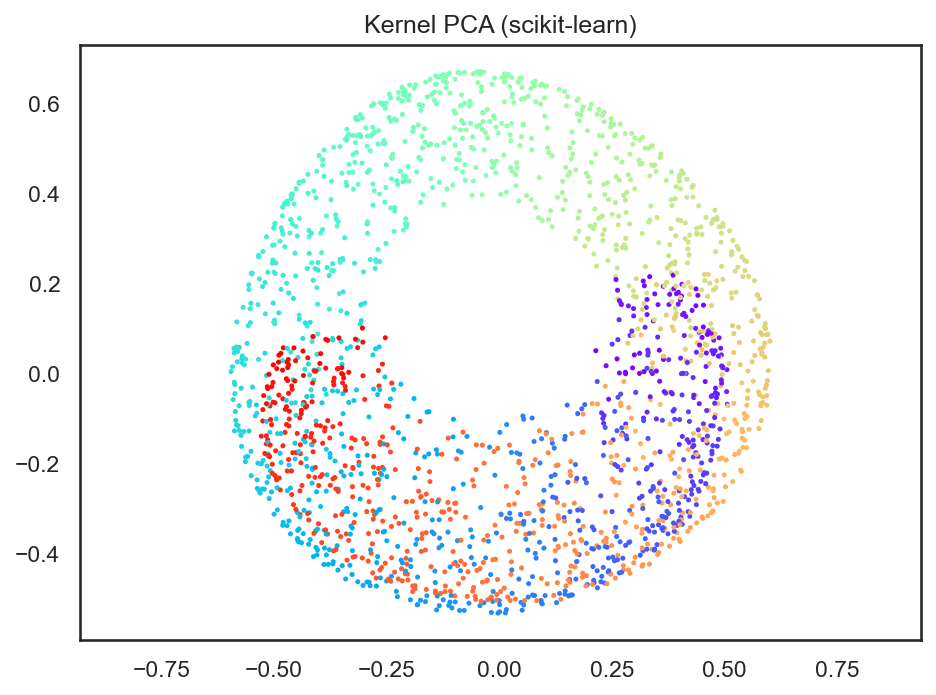

In [38]:
# データの可視化
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
ax.set_title("Kernel PCA (scikit-learn)")
ax.axis("equal")
plt.tight_layout()
plt.show()

ただし、カーネル主成分分析は、カーネル法に用いるカーネルの種類と、そのカーネルを定義するパラメータに大きく依存している。例えば、上記のようにRBFカーネル $k(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \| \mathbf{x}_i - \mathbf{x}_j \|^2)$を用いる場合、$\gamma$変化させることで全く異なる低次元空間表現が与えられる。

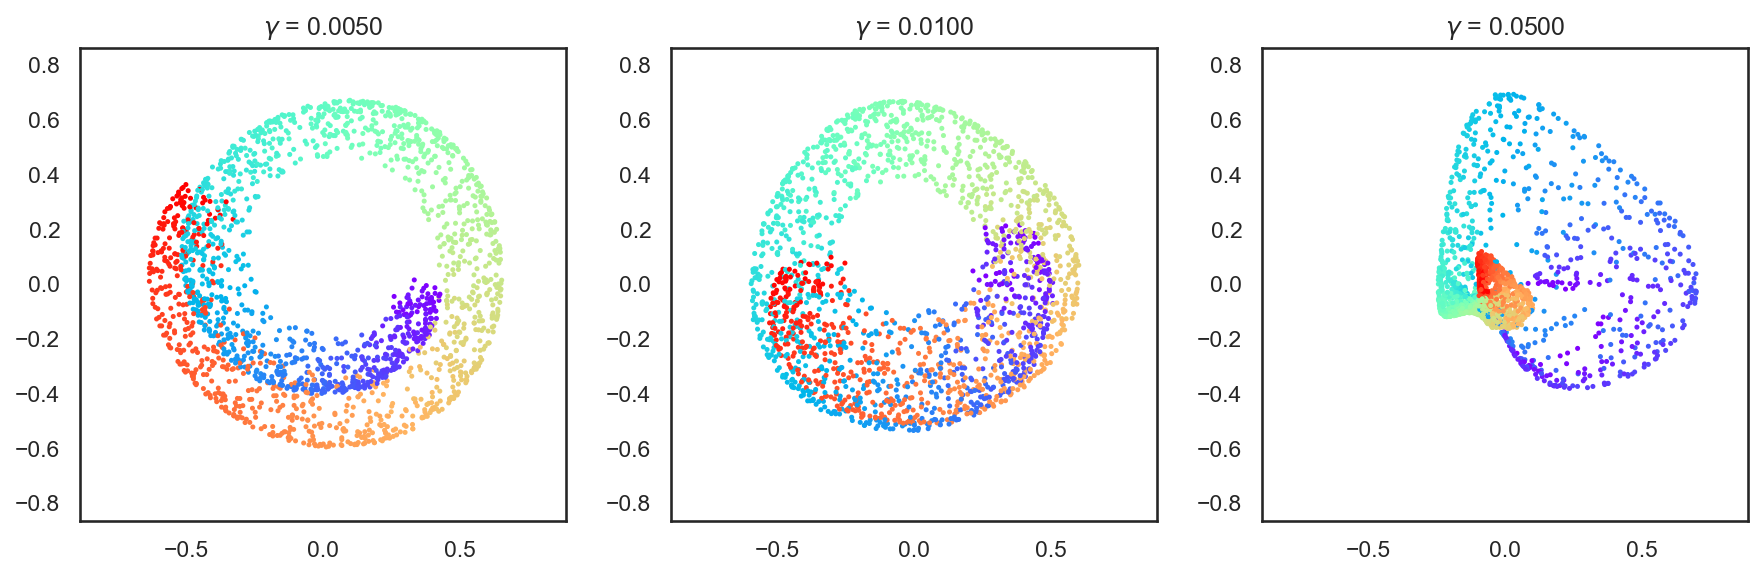

In [39]:
gammas = [0.005, 0.01, 0.05]
fig, axs = plt.subplots(1, len(gammas), figsize=(12, 4))

for i, gamma in enumerate(gammas):
    kpca = KernelPCA(n_components=2, kernel="rbf", gamma=gamma)
    z_sr = kpca.fit_transform(X_sr)

    axs[i].scatter(z_sr[:, 0], z_sr[:, 1], color=c, s=2)
    axs[i].set_title("$\gamma$ = {:.4f}".format(gamma))
    axs[i].axis("equal")
    axs[i].set_xlim([-1.0, 1.0])
    axs[i].set_ylim([-1.0, 1.0])

plt.tight_layout()
plt.show()

これはカーネル主成分分析に限らないが、次元圧縮のアルゴリズムにはいくつかのパラメータがあることがほとんどで、それらを変更すると、全く異なる結果が得られることも多い。従って、scikit-learn等のライブラリを用いる場合も、その背景でどのような計算が行われているのかを考えた上で、パラメータを適切に設定することが大切である。

## MNISTの分析

ここからは、MNISTの手書き文字データに対して、主成分分析とカーネル主成分分析を適用して、データの散らばりを確認するとともに、その画像的意味について考えてみよう。

In [48]:
# 以下のコードはデータのダウンロードを伴うため、少々時間がかかる
X, y = datasets.fetch_openml("mnist_784", return_X_y=True, data_home="./mnist", parser="auto")
X = np.array(X, dtype="uint8")
y = np.array(y, dtype="uint8")

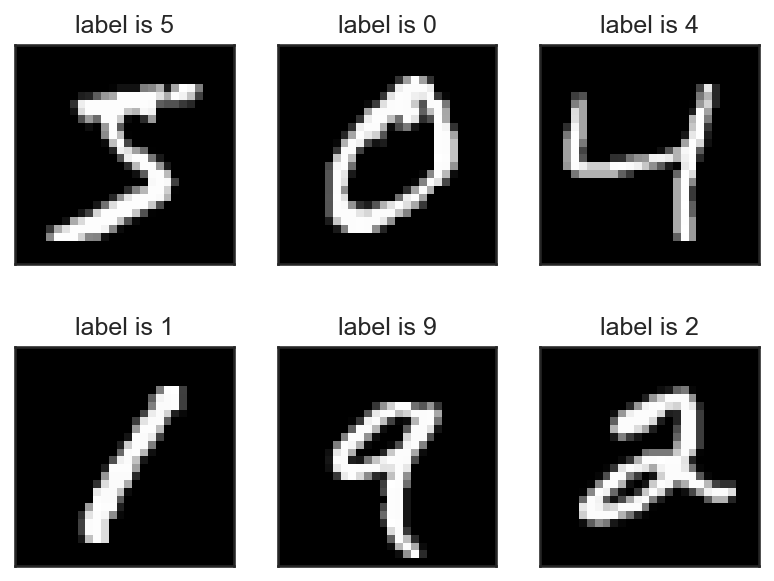

In [49]:
# 画像として見られるように配列の形を変更
ims = np.reshape(X[:6], (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(ims[i], cmap="gray", interpolation=None)
    axs[i].set_title("label is {:d}".format(y[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

例のごとく、実験にかかる時間を短縮するために、先頭{glue}`n_samples`個のデータだけを実験に用いる。

In [50]:
from sklearn import model_selection

X, X_test = model_selection.train_test_split(X, train_size=60000, test_size=10000, shuffle=False)
y, y_test = model_selection.train_test_split(y, train_size=60000, test_size=10000, shuffle=False)

X, y = X[:n_samples], y[:n_samples]

### データ分布の可視化

まずは、MNISTの画像データを784次元のベクトルと見なして、主成分分析により、2次元ベクトルに次元圧縮してみる。ここでは見やすさのために[Seabornの併用](ssec:seaborn)で紹介した`seaborn`の`jointplot`を用いて可視化してみる。

In [51]:
pca = PCA(n_components=2)
z = pca.fit_transform(X)

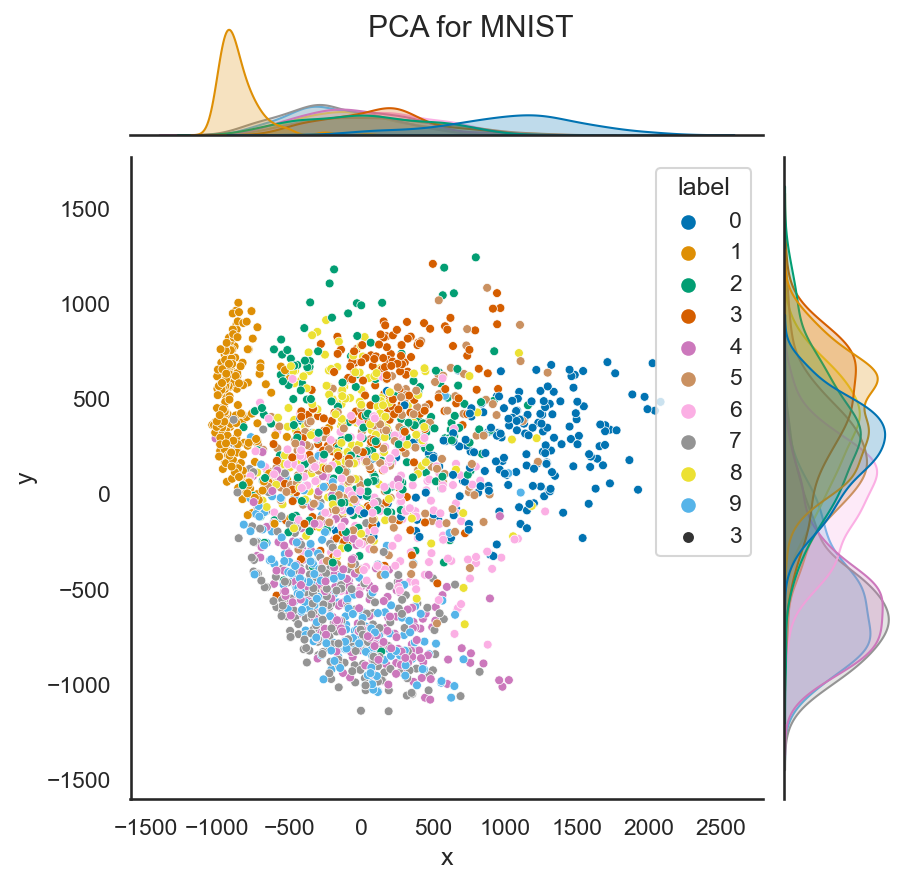

In [84]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "label": y})
sns.jointplot(
    data=df,
    x="x",
    y="y",
    hue="label",
    marker="o",
    size=3,
    palette="colorblind",
)
plt.suptitle("PCA for MNIST")
plt.show()

このように、次元圧縮によって「0」や「1」のデータなど、重なりが少ないデータも見られる一方で、「4」、「6」、「7」のデータなどはかなり重なりが大きいことが分かる。

---

次にカーネル主成分分析を用いて、次元圧縮をしてみよう。やや天下り式ではあるが、今回は以下の式で表わされるコサインカーネルを用いてカーネル主成分分析を実行する。

$$
k(\mathbf{x}_i, \mathbf{x}_j) = \cos(\mathbf{x}_i^\top \mathbf{x}_j)
$$

In [138]:
kpca = KernelPCA(n_components=2, kernel="cosine")
z = kpca.fit_transform(X)

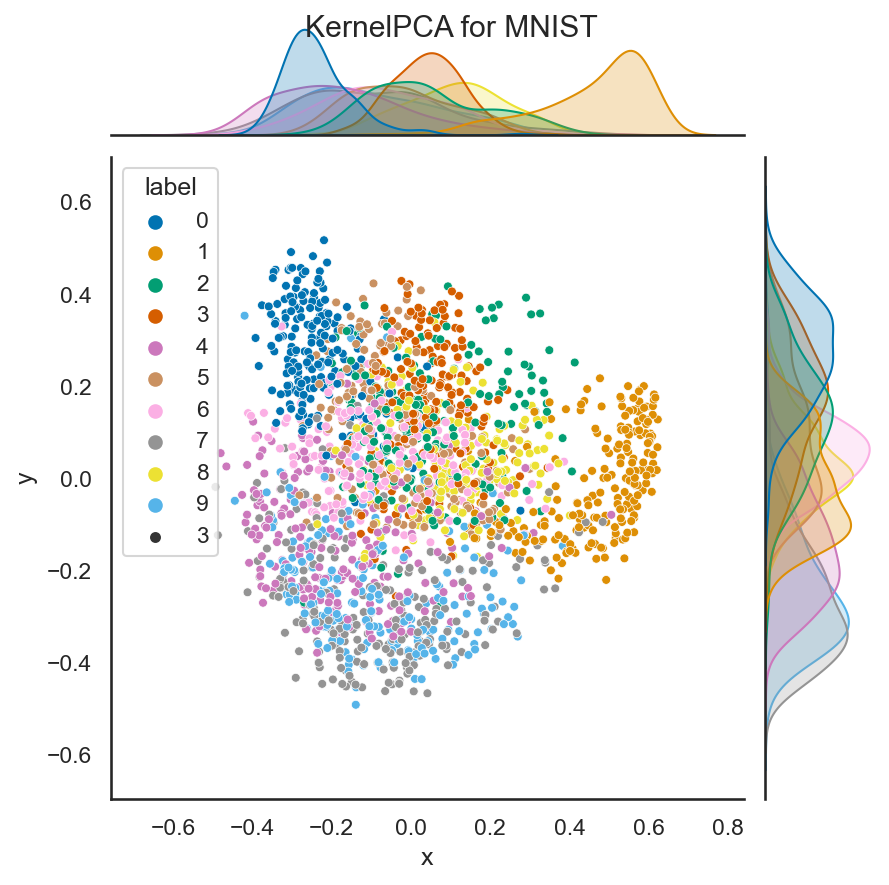

In [139]:
df = pd.DataFrame({"x": z[:, 0], "y": z[:, 1], "label": y})
sns.jointplot(
    data=df,
    x="x",
    y="y",
    hue="label",
    marker="o",
    size=3,
    palette="colorblind",
)
plt.suptitle("KernelPCA for MNIST")
plt.show()

このように、次元圧縮の手法を変化させたことで、各クラスタの重なり具合が多少緩和されていることが分かる。ただし、どのような次元圧縮法であれば、より異なるラベルを持つデータの判別に役立つか、という部分は、明確でない場合が多く、あくまで、データの散らばりを見極める際の目安として、このような可視化結果を用いることが有効であろう。

### 主成分分析の画像的な意味

次にMNISTのデータについて主成分分析をかけてみる。

In [141]:
mu = np.mean(X, axis=1, keepdims=True)
C = np.dot((X - mu).T, (X - mu)) / n_samples

# 固有値分解
eigval, eigvec = np.linalg.eigh(C)

# 固有値が大きい順にソートして、先頭の5つを取り出す
idx = np.flip(np.argsort(eigval))
eigval = eigval[idx[:5]]
eigvec = eigvec[:, idx[:5]].T

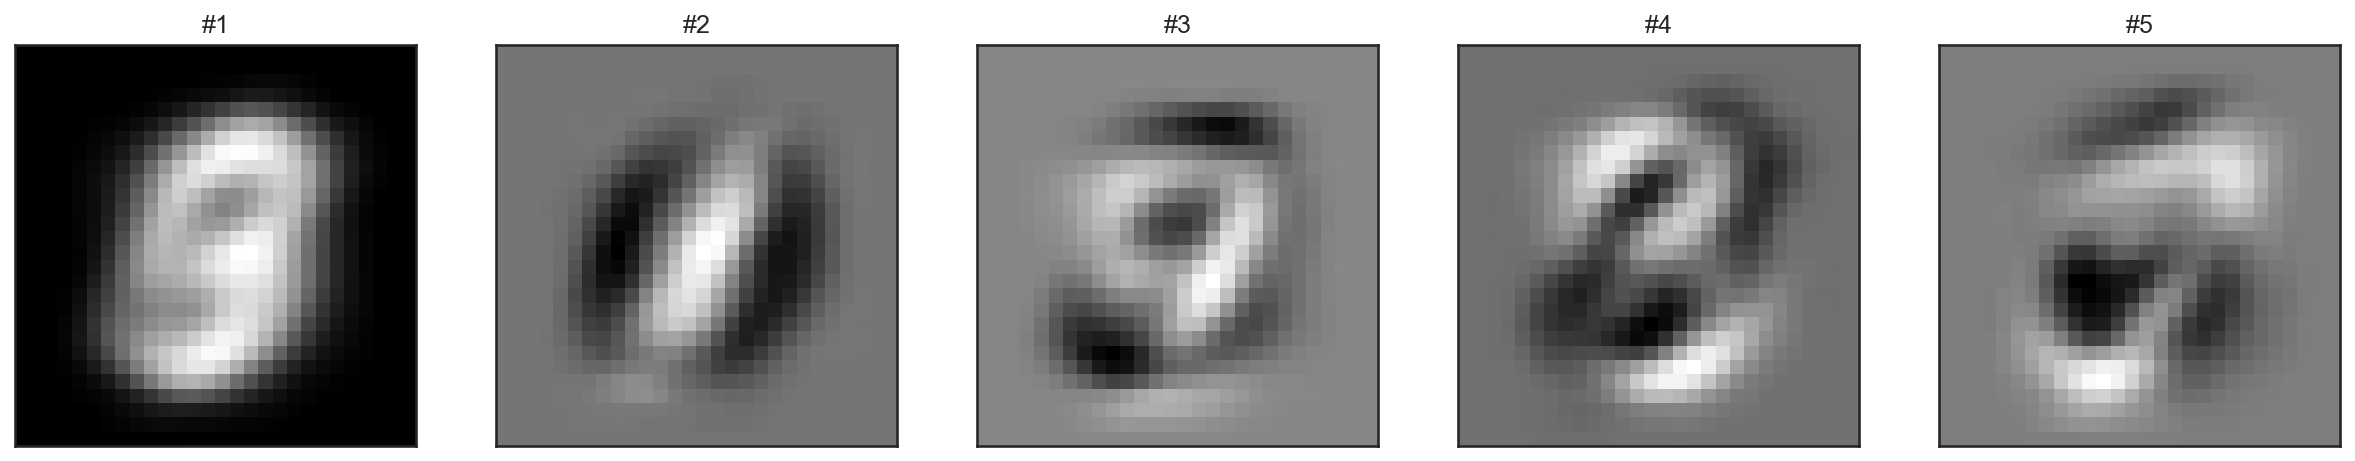

In [142]:
# 画像として見られるように配列の形を変更
ims = np.reshape(eigvec, (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(ims[i], cmap="gray", interpolation=None)
    axs[i].set(title="#{:d}".format(i + 1), xticks=[], yticks=[])
plt.show()

このように得られる固有ベクトルを画像としてみてみると、0から9の数字の影のようなものが見える。定性的には、これらの画像は数字の画像の共通成分のようなものを表わしており、これらの画像の線形結合を取ると、0-9に近しい画像が作れる、というわけである。

以下に、上記の5枚の画像をブレンドすることで、対話的に画像を変更できるシステムを用意してあるので、各自、スライダーを動かすことで画像がどのように変化するかを確認してみてほしい。

In [12]:
import numpy as np
from bokeh.models import Slider, CustomJS, ColumnDataSource
from bokeh.layouts import row, column
from bokeh.plotting import show, figure, output_notebook

output_notebook()

ws = np.random.uniform(-1.0, 1.0, size=(len(ims)))
im_avg = sum([w * im for w, im in zip(ws, ims)])

plot = figure(
    width=300,
    height=300,
    match_aspect=True,
    tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],
)

w1 = Slider(start=-1.0, end=1.0, value=ws[0], step=0.05, title="w1")
w2 = Slider(start=-1.0, end=1.0, value=ws[1], step=0.05, title="w2")
w3 = Slider(start=-1.0, end=1.0, value=ws[2], step=0.05, title="w3")
w4 = Slider(start=-1.0, end=1.0, value=ws[3], step=0.05, title="w4")
w5 = Slider(start=-1.0, end=1.0, value=ws[4], step=0.05, title="w5")

source = ColumnDataSource(
    data={
        "im_avg": [im_avg],
        "im1": [ims[0]],
        "im2": [ims[1]],
        "im3": [ims[2]],
        "im4": [ims[3]],
        "im5": [ims[4]],
    }
)
plot.image(
    image="im_avg",
    source=source,
    x=0,
    y=0,
    dw=im_avg.shape[0],
    dh=im_avg.shape[1],
    palette="Greys256",
)

callback = CustomJS(
    args={"source": source, "w1": w1, "w2": w2, "w3": w3, "w4": w4, "w5": w5},
    code="""
   // Get image data
   const im_avg = source.data['im_avg'][0];
   const im1 = source.data.im1[0];
   const im2 = source.data.im2[0];
   const im3 = source.data.im3[0];
   const im4 = source.data.im4[0];
   const im5 = source.data.im5[0];

   // Get weights
   const w1_ = w1.value;
   const w2_ = w2.value;
   const w3_ = w3.value;
   const w4_ = w4.value;
   const w5_ = w5.value;

   // Image blending
   for (let i = 0; i < im_avg.length; i++) {
        im_avg[i] = w1_ * im1[i] + w2_ * im2[i] + w3_ * im3[i] + w4_ * im4[i] + w5_ * im5[i];
   }
   source.change.emit();
""",
)

w1.js_on_change("value", callback)
w2.js_on_change("value", callback)
w3.js_on_change("value", callback)
w4.js_on_change("value", callback)
w5.js_on_change("value", callback)

show(row(plot, column(w1, w2, w3, w4, w5)))

Loading BokehJS ...

図を見てみると、概ね同じ数字が近くに集まってクラスタを形成していることが分かる。上図は2次元までベクトルを圧縮して作成しているため、数字同士の領域に大きな重複が見られるが、もう少し高い次元であれば、各数字の占める領域が重ならないようにすることができそうだ。

## 練習問題

1. 多次元尺度構成法の項で紹介した{eq}`eq:mds`を自身で導出せよ。
2.  単純なMDSとSMACOFを用いたMDSをMNISTのデータに適用し、違いについて考察せよ。
3.  MNISTのデータについて、コサインカーネルを行った主成分分析により得られる画像を第⑤主成分まで調べて見よ (ヒント: `scikit-learn`の`KernelPCA`で`inverse_transform=True`を用いる)。

## 参考文献

```{bibliography}
:filter: docname in docnames
:style: alpha
```